In [1]:
%pylab inline
import os, csv

Populating the interactive namespace from numpy and matplotlib


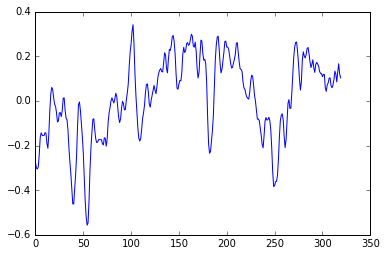

In [2]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [17]:
class RNNNumpy:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.V = np.random.normal(0, 0.1, (word_dim, hidden_dim))
        self.W = np.random.normal(0, 0.1, (hidden_dim , hidden_dim ))
        self.b1 = np.random.normal(0, 0.1, (hidden_dim ))
        

In [18]:
def forward_propagation(self, size, initialState):
    # The total number of time steps
    T = size
    # During forward propagation we save all hidden states in s because need them later.
    s = np.zeros((T , self.hidden_dim))
    #s[-1] = np.ones( self.hidden_dim)
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.word_dim))
    # For each time step...
    for t in np.arange(T):
        s[t] = np.tanh(self.W.dot(s[t-1])+self.b1)
        o[t] = self.V.dot(s[t])
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

In [19]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(len(x), x[1])
    return o

RNNNumpy.predict = predict

In [20]:
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

[[ 0.15930204]
 [ 0.15861779]
 [ 0.13492535]
 [ 0.10207609]
 [ 0.05743071]
 [ 0.18147322]
 [ 0.24238388]
 [ 0.20354417]
 [ 0.27938585]
 [ 0.41234395]
 [ 0.37204439]
 [ 0.33866518]
 [ 0.35304053]
 [ 0.33497561]
 [ 0.35650146]
 [ 0.41513555]
 [ 0.45549143]
 [ 0.34206971]
 [ 0.30181983]
 [ 0.32044282]
 [ 0.25203292]
 [ 0.28052087]
 [ 0.34997168]
 [ 0.37325046]
 [ 0.30172907]
 [ 0.29696282]
 [ 0.3209988 ]
 [ 0.26374331]
 [ 0.31029734]
 [ 0.35698454]
 [ 0.34688804]
 [ 0.34139363]
 [ 0.37206599]
 [ 0.37473605]
 [ 0.31989359]
 [ 0.36247968]
 [ 0.37395579]
 [ 0.33444023]
 [ 0.35282918]
 [ 0.37507315]
 [ 0.34846393]
 [ 0.31659582]
 [ 0.3470192 ]
 [ 0.3250381 ]
 [ 0.29740535]
 [ 0.33731846]
 [ 0.34582033]
 [ 0.31850589]
 [ 0.32553142]
 [ 0.35157697]
 [ 0.31786102]
 [ 0.31586639]
 [ 0.35902723]
 [ 0.34982309]
 [ 0.3351886 ]
 [ 0.35920021]
 [ 0.36413886]
 [ 0.32693966]
 [ 0.34165706]
 [ 0.36210712]
 [ 0.33274747]
 [ 0.3351231 ]
 [ 0.35731277]
 [ 0.34178765]
 [ 0.31772486]
 [ 0.34327922]
 [ 0.34225

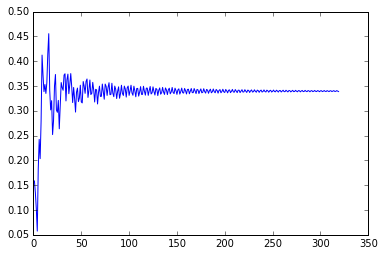

In [22]:
model = RNNNumpy(1)
X_train = data[4][:,0]
o = model.predict(X_train)
print(o)
print(o.shape)
plot(o)

In [23]:
def calculate_loss(self, x):
    o, s = self.forward_propagation(len(x), x[1])
    o=o.reshape(x.shape)
    return ((x-o)*(x-o)).sum()
model.calculate_loss=calculate_loss

In [24]:
loss = model.calculate_loss(model, X_train)
loss

43.380343749108526

In [10]:
def bptt(self, x):
    T = len(x)
    # Perform forward propagation
    o, s = self.forward_propagation(len(x), x[1])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdb1 = np.zeros(self.b1.shape)
    delta_o = o - x
    #delta_o[np.arange(len(x)), x] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            dLdW += np.outer(delta_t, s[bptt_step-1])
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdV, dLdW]

RNNNumpy.bptt = bptt

In [11]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, learning_rate):
    # Calculate the gradients
    dLdV, dLdW = self.bptt(x)
    # Change parameters according to gradients and learning rate
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [12]:
# Outer SGD Loop
# - model: The RNN model instance
# - x: séquence to generate
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, x, learning_rate=0.0003, nepoch=100):
    # We keep track of the losses so we can plot them later
    losses = []
    for epoch in range(nepoch):
        # One SGD step
        loss = model.calculate_loss(model,x)
        losses.append(loss)
        model.sgd_step(x, learning_rate)
        
    return losses
 

In [13]:
losses = train_with_sgd(model, X_train, nepoch=100)

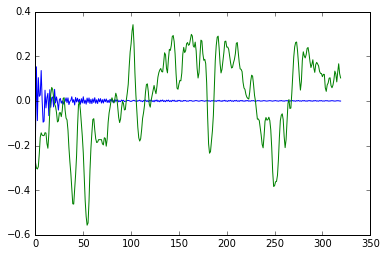

In [14]:
o = model.predict(X_train)
plot(o)
plot(X_train)

[18.439412247544162,
 13.122749024440335,
 12.255428606931229,
 11.851313885797392,
 11.615524168205861,
 11.462263646699558,
 11.356341334883631,
 11.28030131673566,
 11.224340671760856,
 11.182449528689338,
 11.150698520600502,
 11.126393235820554,
 11.107620652122966,
 11.092988605588626,
 11.081466950479914,
 11.072285403205758,
 11.064864642438749,
 11.058767915625669,
 11.053665932852159,
 11.049310792231221,
 11.045516311899798,
 11.042143065376713,
 11.039086955359181,
 11.036270489921193,
 11.033636137864836,
 11.031141286583219,
 11.028754432759085,
 11.026452317682736,
 11.024217782637749,
 11.022038170141345,
 11.019904136695459,
 11.017808774149554,
 11.015746961397987,
 11.013714887251306,
 11.011709700035784,
 11.009729250709171,
 11.007771904792476,
 11.005836404823523,
 11.003921769830534,
 11.002027221890888,
 11.000152132483343,
 10.998295983292746,
 10.99645833756199,
 10.994638819139151,
 10.9928370971391,
 10.991052874702511,
 10.989285880746628,
 10.9875358639019

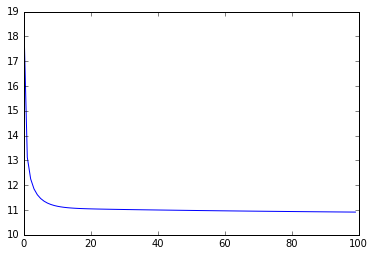

In [15]:
plot(losses)
losses

17.704175793299104

array([4, 3, 2, 1, 0])